In [1]:
# Base Data Science snippet
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import time
from tqdm import tqdm_notebook
from scipy.spatial.distance import cdist
import imageio
from matplotlib.patches import Rectangle
from matplotlib.collections import PatchCollection

plt.style.use("seaborn-dark")

import sys
sys.path.append("../")
from rl.agents.q_agent import QAgent

In [2]:
np.loadtxt('test3.csv', delimiter=",")

array([[ 0.        ,  0.        ],
       [ 5.16601049,  5.16601049],
       [ 6.00383107,  0.        ],
       [ 6.74624857,  4.57775407],
       [ 3.35733921,  0.        ],
       [-1.05853617,  5.96498441],
       [-4.35714012,  0.        ],
       [-6.86150897,  4.52874046],
       [-5.43523257,  0.        ],
       [-3.67879414,  5.5770773 ],
       [ 1.59123526,  0.        ],
       [ 6.14561503,  4.81973175],
       [ 6.25961144,  0.        ],
       [ 6.37151786,  4.73136751],
       [ 2.10060475,  0.        ],
       [-3.05261581,  5.70879802],
       [-5.18350802,  0.        ],
       [-6.87221193,  4.52414698],
       [-4.66373125,  0.        ],
       [-1.7833208 ,  5.90061772],
       [ 2.95058046,  0.        ],
       [ 6.65413247,  4.61632878],
       [ 6.13436055,  0.        ],
       [ 5.56787524,  5.03121141],
       [ 0.57182085,  0.        ],
       [-4.70059122,  5.30951382],
       [-5.83448301,  0.        ],
       [-6.80663909,  4.55217701],
       [-3.73195449,

In [3]:
class Environment(object):
    
    def __init__(self, n_stops=8,method="angle_difference", **kwargs):
        
        print(f"Initialized Delivery Environment with {n_stops} random stops")
        print(f"Target metric for optimization is {method}")
              
        #Initializaiton 
        self.n_stops = n_stops
        self.action_space = self.n_stops
        self.observation_space = self.n_stops
        self.stops = []
        self.method = method
        
        
        #Generate Stops 
        self._generate_stops()
        self._generate_q_values()
        self.render
        self.reset()
        
        
    def _generate_stops(self):
        
        xy = np.loadtxt('test3.csv', delimiter=",")
        self.x = xy[:,0]
        self.y = xy[:,1]
        
    def _generate_q_values(self):
        xy = np.column_stack([self.x,self.y])
        mat =  np.zeros((len(xy), len(xy)))
        for i in range(len(xy)):
            for j in range(len(xy)):
                if (xy[j][1]-xy[i][1]) ==0:
                    mat[i][j] = -100
                elif (xy[j][1]!=0) and (xy[i][1]!=0):
                    mat[i][j] = -100
                else: 
                    mat[i][j] = (xy[j][0]-xy[i][0])/(xy[j][1]-xy[i][1])
        self.q_stops = mat
        
    def render(self,return_img = False):
        
        fig = plt.figure(figsize=(7,7))
        ax = fig.add_subplot(111)
        ax.set_title("Paths")

        # Show stops
        ax.scatter(self.x,self.y,c = "red",s = 50)

        # Show START
        if len(self.stops)>0:
            xy = self._get_xy(initial = True)
            xytext = xy[0]+0.1,xy[1]-0.05
            ax.annotate("START",xy=xy,xytext=xytext,weight = "bold")

        # Show itinerary
        if len(self.stops) > 1:
            ax.plot(self.x[self.stops],self.y[self.stops],c = "blue",linewidth=1,linestyle="--")
            
            # Annotate END
            xy = self._get_xy(initial = False)
            xytext = xy[0]+0.1,xy[1]-0.05
            ax.annotate("END",xy=xy,xytext=xytext,weight = "bold")

        plt.xticks([])
        plt.yticks([])
        
        if return_img:
            # From https://ndres.me/post/matplotlib-animated-gifs-easily/
            fig.canvas.draw_idle()
            image = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')
            image  = image.reshape(fig.canvas.get_width_height()[::-1] + (3,))
            plt.close()
            return image
        else:
            plt.show()
    
    def reset(self):

        # Stops placeholder
        self.stops = [0]

        # Random first stop
        return self.stops[-1]

    def step(self,destination):

        # Get current state
        state = self._get_state()
        new_state = destination

        # Get reward for such a move
        reward = self._get_reward(state,new_state)

        # Append new_state to stops
        self.stops.append(destination)
        done = len(self.stops) == self.n_stops

        return new_state,reward,done

    def _get_state(self):
        return self.stops[-1]


    def _get_xy(self,initial = False):
        state = self.stops[0] if initial else self._get_state()
        x = self.x[state]
        y = self.y[state]
        return x,y


    def _get_reward(self,state,new_state):
        base_reward = self.q_stops[state,new_state]
        return base_reward


def run_episode(env,agent,verbose = 1):

    s = env.reset()
    agent.reset_memory()

    max_step = env.n_stops
    
    episode_reward = 0
    
    i = 0
    while i < max_step:

        # Remember the states
        agent.remember_state(s)

        # Choose an action
        a = agent.act(s,episode_reward)
        
        # Take the action, and get the reward from environment
        s_next,r,done = env.step(a)

        # Tweak the reward
        r = r
        
        if verbose: print(s_next,r,done)
        
        # Update our knowledge in the Q-table
        agent.train(s,a,r,s_next)
        
        # Update the caches
        episode_reward += r
        s = s_next
        
        # If the episode is terminated
        i += 1
        if done:
            break
            
    return env,agent,episode_reward



class DeliveryQAgent(QAgent):

    def __init__(self,*args,**kwargs):
        super().__init__(*args,**kwargs)
        self.reset_memory()

    def act(self,s,rewards):

        # Get Q Vector
        q = np.copy(self.Q[s,:])

        # Avoid already visited states
        q[self.states_memory] = -np.inf

        if np.random.rand() > self.epsilon:
            a_candidates = [x for x in range(self.actions_size) if x not in self.states_memory]
            min_sub = np.inf
            a = None
            for candidate in a_candidates:
                diff = rewards-candidate
                if diff<min_sub:
                    min_sub = diff
                    a = candidate   
        else:
            a = np.random.choice([x for x in range(self.actions_size) if x not in self.states_memory])

        return a


    def remember_state(self,s):
        self.states_memory.append(s)

    def reset_memory(self):
        self.states_memory = []



def run_n_episodes(env,agent,name="training.gif",name2 = "low_reward.gif", n_episodes=1000,render_each=5,fps=10):

    # Store the rewards
    rewards = []
    imgs = []
    imgs2 = []

    # Experience replay
    for i in tqdm_notebook(range(n_episodes)):

        # Run the episode
        env,agent,episode_reward = run_episode(env,agent,verbose = 0)
        rewards.append(episode_reward)
            
        if i % render_each == 0:
            img = env.render(return_img = True)
            imgs.append(img)
        
        if episode_reward>-10:
            img = env.render(return_img = True)
            imgs2.append(img)
        
    
    
    # Show rewards
    plt.figure(figsize = (15,3))
    plt.title("Rewards over training")
    plt.plot(rewards)
    plt.show()
    
    # Save imgs as gif
    imageio.mimsave(name,imgs,fps = fps)
    imageio.mimsave(name2,imgs2,fps = fps)

    return env,agent,rewards

In [4]:
env = Environment()
print(env.q_stops)

Initialized Delivery Environment with 8 random stops
Target metric for optimization is angle_difference
[[-1.00000000e+02  1.00000000e+00 -1.00000000e+02 ...  4.09316010e-01
  -1.00000000e+02  1.52004813e+00]
 [ 1.00000000e+00 -1.00000000e+02 -1.62179419e-01 ... -1.00000000e+02
   4.93087180e-02 -1.00000000e+02]
 [-1.00000000e+02 -1.62179419e-01 -1.00000000e+02 ... -6.21826343e-01
  -1.00000000e+02  1.92625366e-01]
 ...
 [ 4.09316010e-01 -1.00000000e+02 -6.21826343e-01 ... -1.00000000e+02
  -4.34183737e-01 -1.00000000e+02]
 [-1.00000000e+02  4.93087180e-02 -1.00000000e+02 ... -4.34183737e-01
  -1.00000000e+02  4.34183737e-01]
 [ 1.52004813e+00 -1.00000000e+02  1.92625366e-01 ... -1.00000000e+02
   4.34183737e-01 -1.00000000e+02]]


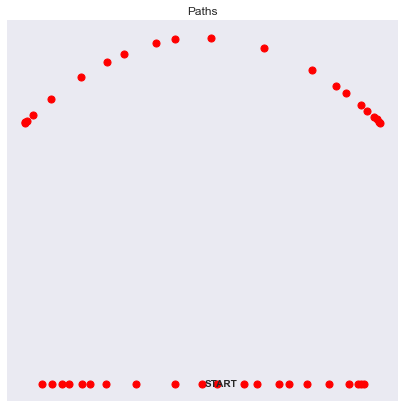

In [5]:
env.render()

In [6]:
env.stops

[0]

In [7]:
for i in [7,2]:
    env.step(i)

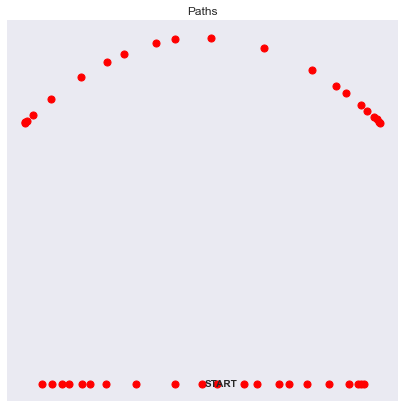

In [8]:
env.reset()
env.render()

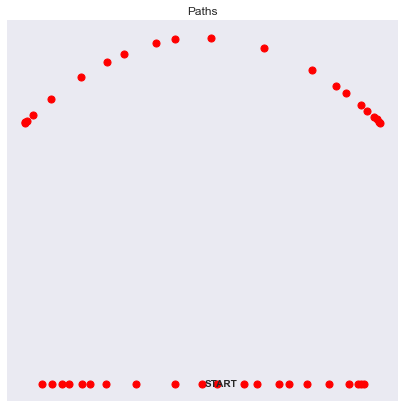

In [9]:
env.render()

In [10]:
env = Environment(n_stops = 42,method = "angle_difference" )

Initialized Delivery Environment with 42 random stops
Target metric for optimization is angle_difference


In [11]:
agent = DeliveryQAgent(env.observation_space,env.action_space)

C:\Users\PC\AppData\Local\Temp/ipykernel_9004/3070428024.py:205: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm_notebook(range(n_episodes)):


  0%|          | 0/1000 [00:00<?, ?it/s]

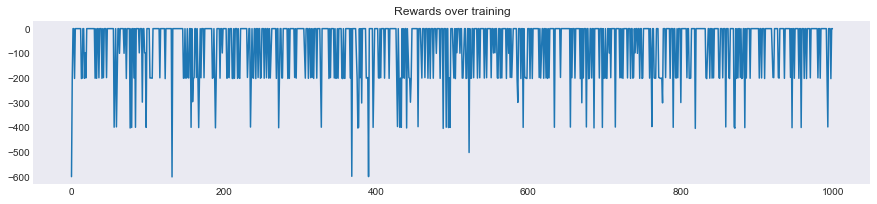

In [12]:
a, b, c = run_n_episodes(env,agent,"training_42_pts.gif", "low_reward_42.gif")

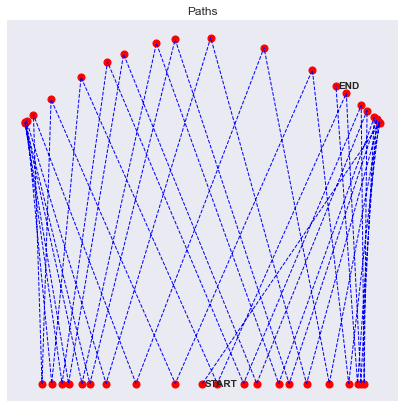

In [13]:
env.render()

In [14]:
np.sort(c)[-500:]

array([-598.95331324, -598.01328025, -597.86566971, -596.6294939 ,
       -500.15302611, -402.58538806, -402.50033744, -401.68732909,
       -401.0690442 , -400.94127705, -400.81225732, -400.56196027,
       -400.26134413, -399.86333536, -399.76096284, -399.44378308,
       -399.22106917, -399.19648305, -398.89681344, -398.72563734,
       -398.71772577, -398.58509534, -398.46197324, -398.44944656,
       -398.43690614, -398.41830602, -398.27036547, -398.2539641 ,
       -398.10669679, -398.03893716, -397.89111741, -397.88444084,
       -397.82378623, -397.75071326, -397.7144385 , -397.32071404,
       -397.15011509, -397.1324923 , -396.7975394 , -396.71720443,
       -396.60157013, -396.54420146, -396.38731966, -395.60217188,
       -395.27432741, -395.06593633, -299.67789856, -299.14883751,
       -298.71374025, -297.82893369, -297.21693036, -296.4770904 ,
       -296.23162318, -294.58965055, -201.02717746, -201.00583379,
       -200.95275816, -200.89026632, -200.83786871, -200.76777

In [15]:
env.reset()

0

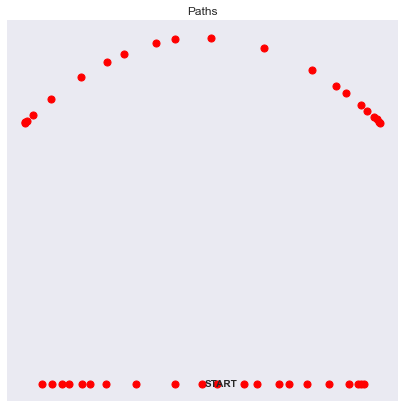

In [16]:
env.render()

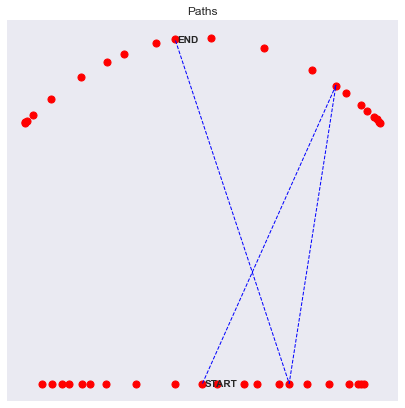

In [17]:
env.reset()
for i in [0,1]:
    env.step(i)
for i in[1, 4, 5]:
    env.step(i)
env.render()

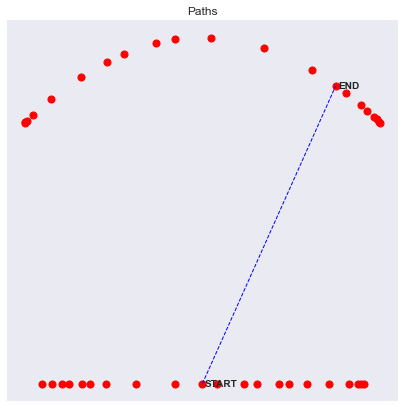

In [18]:
env.reset()
for i in [0,1]:
    env.step(i)
env.render()